In [1]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import export_text

In [7]:
# Read in Data from CSV
raw_data = np.genfromtxt("lk_pressed.csv", delimiter=',')
# Convert Integer Time to Float ime
# Since we will have several readings with the same time in the csv, 
# we have to split these up by millisecond intervals
# If we have five readings at 67 seconds, we will split them up into 5 time slots
# 67.0, 67.2, 67.4, 67.6, 67.8


running_list_x = []
running_list_y = []
# Final values to be stored in the DataFrame
final_x = []
final_y = []


prev = 0
total = 0
for x,y in raw_data:
    
    # if the times are the same, then we append the vals to a running list
    if x == prev:
        running_list_x.append(x)
        running_list_y.append(y)

    # if the times are different, then we can break up the 
    # millisecond based on how many sensor readings we got
    else:
        for index, i in enumerate(running_list_x):
            final_x.append(min(running_list_x) + (index + 1) / len(running_list_x))
            final_y.append(running_list_y[index])
        running_list_x = []
        running_list_y = []
    prev = x
    


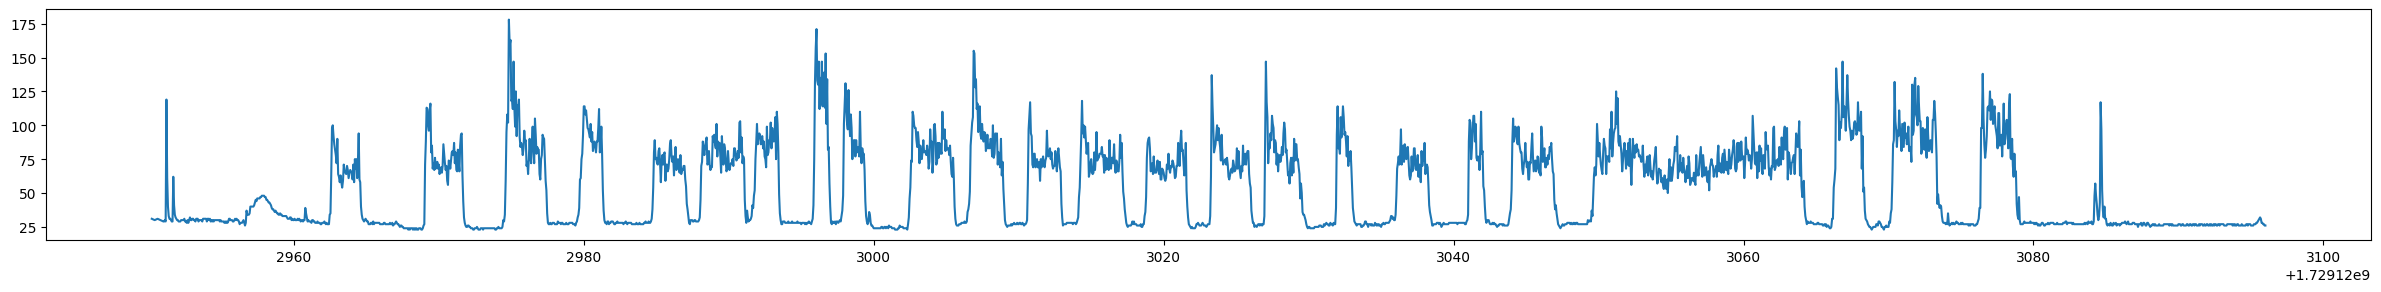

,Time,Signal
174,0.000000,31.0
175,0.052632,30.0
176,0.105263,30.0
177,0.157895,30.0
178,0.210526,31.0


2572


In [9]:
# Initial Plot
plt.figure(figsize=(30, 3))
plt.plot(final_x, final_y)
plt.show()

# Create a Pandas DataFrame
orignal = pd.DataFrame({"Time": final_x[1:], "Signal": final_y[1:]})

# Filter out data before the start time
df = orignal[orignal["Time"] > 1729122960].copy()

#Standardize time so the first point is at 0 seconds
df["Time"] = df["Time"] - min(df["Time"])

# Print
display(df.head())
print(len(df))

In [11]:
#Known open and closed intervals
interval_times = [2.34, 2.14, 4.24, 2.72, 2.94, 2.81,
                  2.39, 1.71, 3.36, 2.39, 0.93, 2.89,
                  0.73, 1.54, 2.37, 1.14, 0.79, 1.59,
                  3.06, 3.11, 1.09, 2.29, 1.59, 2.28,
                  1.31, 3.02, 1.48, 2.84, 1.66, 2.86,
                  0.93, 2.56, 2.36, 1.18, 2.94, 2.29,
                  2.67, 1.41, 1.48, 3.11, 2.92, 14.24,
                  2.23, 1.96, 2.08, 3.12, 2.87, 2.31,
                  2.29]

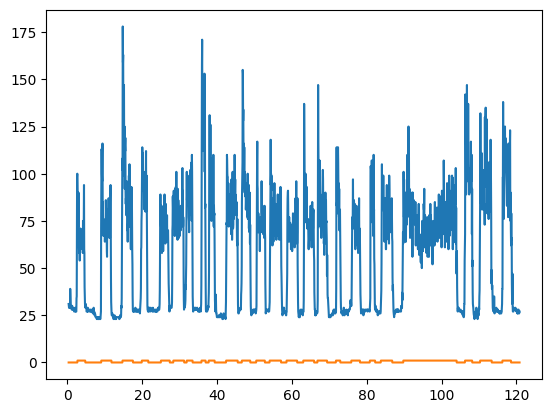

In [19]:
# Throw out data before here
start_time = 0.3

# Label each point with a State based on the interval
for i in range(len(interval_times)):
    
    end_time = start_time + interval_times[i]
    
    df.loc[df["Time"].between(start_time, end_time), "State"] = i%2
            
    start_time = end_time
    
# Plot Data
plt.plot(df["Time"], df["Signal"])
plt.plot(df["Time"], df["State"])

# Removes any numbers which are infinity or NaN
df = df[df["State"].apply(lambda x: not (pd.isna(x) or x in [float('inf'), float('-inf')]))]

plt.show()

In [32]:
slice_length = 5


mean_list = []
max_list = []
min_list = []
range_list = []
last_list = []
second_list = []
state_list = []


# Take slice_length number of signal points
for i in range(0, len(df) - slice_length + 1):
    current_frame = df.iloc[i: i + slice_length - 1]
    
    #plt.figure(figsize = (6,4))
    
    # Standard features
    mean_list.append(current_frame[ "Signal" ].mean())
    max_list.append(current_frame[ "Signal" ].max())
    min_list.append(current_frame[ "Signal" ].min())
    range_list.append(max_val - min_val)

    # Other features of interest
    last_list.append(current_frame.iloc[-1]["Signal"])
    second_list.append(current_frame.iloc[-2]["Signal"])
    
    # State, Y
    state_list.append(current_frame.iloc[-1]["State"])
    
# Make feature df for random forest
feature_df = pd.DataFrame({"Mean": mean_list, 
                           "Max": max_list, 
                           "Min": min_list, 
                           "Range": range_list,
                           "Last Val": last_list, 
                           "2nd Last Val": second_list, 
                           "State": state_list})


print (feature_df.head(200))

      Mean   Max   Min  Range  Last Val  2nd Last Val  State
0    30.00  31.0  29.0    1.0      30.0          29.0    0.0
1    29.75  30.0  29.0    1.0      30.0          30.0    0.0
2    29.50  30.0  29.0    1.0      29.0          30.0    0.0
3    29.75  30.0  29.0    1.0      30.0          29.0    0.0
4    29.75  30.0  29.0    1.0      30.0          30.0    0.0
..     ...   ...   ...    ...       ...           ...    ...
195  72.25  74.0  68.0    1.0      74.0          68.0    1.0
196  73.75  80.0  68.0    1.0      80.0          74.0    1.0
197  75.75  81.0  68.0    1.0      81.0          80.0    1.0
198  78.25  81.0  74.0    1.0      78.0          81.0    1.0
199  81.50  87.0  78.0    1.0      87.0          78.0    1.0

[200 rows x 7 columns]


In [39]:
# Features and target
X = feature_df[["Mean", "Max", "Min", "Range", "Last Val", "2nd Last Val"]]  # Features
y = feature_df["State"]  # Target
y = y.astype(int)


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Make random forest
model = RandomForestClassifier(random_state=42, max_features=2, max_depth=3)
model.fit(X_train, y_train)


# Use test test for prediction
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:")
print(importance)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       288
           1       0.98      0.95      0.97       395

    accuracy                           0.96       683
   macro avg       0.96      0.96      0.96       683
weighted avg       0.96      0.96      0.96       683

Confusion Matrix:
[[281   7]
 [ 19 376]]

Feature Importance:
        Feature  Importance
0          Mean    0.284240
4      Last Val    0.243943
2           Min    0.220369
5  2nd Last Val    0.177737
1           Max    0.073712
3         Range    0.000000


In [41]:
# Assuming your RandomForest model is already trained
# Extract the first decision tree from the Random Forest
tree = model.estimators_[0]

# Get the decision rules for the tree
tree_rules = export_text(tree, feature_names=X.columns.tolist())

# Print the decision rules (splits and thresholds used in the first tree)
print(tree_rules)

|--- Min <= 51.50
|   |--- 2nd Last Val <= 31.50
|   |   |--- Last Val <= 31.50
|   |   |   |--- class: 0.0
|   |   |--- Last Val >  31.50
|   |   |   |--- class: 0.0
|   |--- 2nd Last Val >  31.50
|   |   |--- Max <= 73.50
|   |   |   |--- class: 0.0
|   |   |--- Max >  73.50
|   |   |   |--- class: 1.0
|--- Min >  51.50
|   |--- Last Val <= 56.50
|   |   |--- Mean <= 65.00
|   |   |   |--- class: 1.0
|   |   |--- Mean >  65.00
|   |   |   |--- class: 0.0
|   |--- Last Val >  56.50
|   |   |--- Max <= 90.50
|   |   |   |--- class: 1.0
|   |   |--- Max >  90.50
|   |   |   |--- class: 1.0

